In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.backends.cudnn as cudnn
import tqdm

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader,Subset
import torchvision.models as models
import torch.nn.functional as F

import sys
import os
sys.path.append(os.path.abspath(".."))
from models import *
import copy
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from util import *

random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

torch.cuda.set_device(0)
device = 'cuda'
dataset_path = '/narcissus/dataset/'

In [12]:
import os
import torchvision
import torchvision.transforms as transforms

dataset_path = os.path.expanduser("~/datasets/")
cifar10_path = os.path.join(dataset_path, "cifar-10-batches-py")

if not os.path.exists(cifar10_path):
    print("Downloading CIFAR-10...")
    torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True)
    torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True)
else:
    print("CIFAR-10 already downloaded.")


CIFAR-10 already downloaded.


In [13]:
import os
import urllib.request
import zipfile

tiny_imagenet_dir = os.path.join(dataset_path, "tiny-imagenet-200")

if not os.path.exists(tiny_imagenet_dir):
    print("Downloading Tiny ImageNet...")
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = os.path.join(dataset_path, "tiny-imagenet-200.zip")
    
    urllib.request.urlretrieve(url, zip_path)

    print("Extracting Tiny ImageNet...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    
    os.remove(zip_path)
    print("Done.")
else:
    print("Tiny ImageNet already downloaded.")


Tiny ImageNet already downloaded.


In [14]:
'''
The path for target dataset and public out-of-distribution (POOD) dataset. The setting used 
here is CIFAR-10 as the target dataset and Tiny-ImageNet as the POOD dataset. Their directory
structure is as follows:

dataset_path--cifar-10-batches-py
            |
            |-tiny-imagenet-200
'''
# dataset_path = '/home/minzhou/data/'

#The target class label
lab = 2

#Noise size, default is full image size
noise_size = 32

#Radius of the L-inf ball
l_inf_r = 16/255

#Model for generating surrogate model and trigger
surrogate_model = ResNet18_201().cuda()
generating_model = ResNet18_201().cuda()

#Surrogate model training epochs
surrogate_epochs = 200

#Learning rate for poison-warm-up
generating_lr_warmup = 0.1
warmup_round = 5

#Learning rate for trigger generating
generating_lr_tri = 0.01      
gen_round = 1000

#Training batch size
train_batch_size = 350

#The model for adding the noise
patch_mode = 'add'

# Prepare dataset

In [15]:
#The argumention use for surrogate model training stage
transform_surrogate_train = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all testing set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [16]:
ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_train)
ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_test)
outter_trainset = torchvision.datasets.ImageFolder(root=dataset_path + 'tiny-imagenet-200/train/', transform=transform_surrogate_train)

In [17]:
#Outter train dataset
train_label = [get_labels(ori_train)[x] for x in range(len(get_labels(ori_train)))]
test_label = [get_labels(ori_test)[x] for x in range(len(get_labels(ori_test)))]

In [18]:
#Inner train dataset
train_target_list = list(np.where(np.array(train_label)==lab)[0])
train_target = Subset(ori_train,train_target_list)

In [19]:
concoct_train_dataset = concoct_dataset(train_target,outter_trainset)

In [20]:
surrogate_loader = torch.utils.data.DataLoader(concoct_train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=16)

poi_warm_up_loader = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

trigger_gen_loaders = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

#  Training surrogate modle

In [ ]:
# Batch_grad
condition = True
noise = torch.zeros((1, 3, noise_size, noise_size), device=device)


surrogate_model = surrogate_model
criterion = torch.nn.CrossEntropyLoss()
# outer_opt = torch.optim.RAdam(params=base_model.parameters(), lr=generating_lr_outer)
surrogate_opt = torch.optim.SGD(params=surrogate_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
surrogate_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(surrogate_opt, T_max=surrogate_epochs)

In [ ]:
save_path = 'surrogate_pretrain_' + str(surrogate_epochs) +'.pth'

if os.path.exists(save_path):
    print(f"Loading pre-trained surrogate model from {save_path}")
    surrogate_model.load_state_dict(torch.load(save_path))
else:
    print('Training the surrogate model')
    for epoch in range(0, surrogate_epochs):
        surrogate_model.train()
        loss_list = []
        for images, labels in surrogate_loader:
            images, labels = images.cuda(), labels.cuda()
            surrogate_opt.zero_grad()
            outputs = surrogate_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            loss_list.append(float(loss.data))
            surrogate_opt.step()
        surrogate_scheduler.step()
        ave_loss = np.average(np.array(loss_list))
        print('Epoch:%d, Loss: %.03f' % (epoch, ave_loss))
    
    torch.save(surrogate_model.state_dict(), save_path)


# Poison warm up

In [ ]:
#cell 13
#Prepare models and optimizers for poi_warm_up training
poi_warm_up_model = generating_model
poi_warm_up_model.load_state_dict(surrogate_model.state_dict())

poi_warm_up_opt = torch.optim.RAdam(params=poi_warm_up_model.parameters(), lr=generating_lr_warmup)

In [ ]:
#cell 14
#Poi_warm_up stage
poi_warm_up_model.train()
for param in poi_warm_up_model.parameters():
    param.requires_grad = True

#Training the surrogate model
for epoch in range(0, warmup_round):
    poi_warm_up_model.train()
    loss_list = []
    for images, labels in poi_warm_up_loader:
        images, labels = images.cuda(), labels.cuda()
        poi_warm_up_model.zero_grad()
        poi_warm_up_opt.zero_grad()
        outputs = poi_warm_up_model(images)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph = True)
        loss_list.append(float(loss.data))
        poi_warm_up_opt.step()
    ave_loss = np.average(np.array(loss_list))
    print('Epoch:%d, Loss: %e' % (epoch, ave_loss))

# Trigger generating

In [ ]:
#cell 15
from tqdm.notebook import tqdm

#Trigger generating stage
for param in poi_warm_up_model.parameters():
    param.requires_grad = False

batch_pert = torch.autograd.Variable(noise.cuda(), requires_grad=True)
batch_opt = torch.optim.RAdam(params=[batch_pert],lr=generating_lr_tri)
for minmin in tqdm(range(gen_round)):
    loss_list = []
    for images, labels in trigger_gen_loaders:
        images, labels = images.cuda(), labels.cuda()
        new_images = torch.clone(images)
        clamp_batch_pert = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
        new_images = torch.clamp(apply_noise_patch(clamp_batch_pert,new_images.clone(),mode=patch_mode),-1,1)
        per_logits = poi_warm_up_model.forward(new_images)
        loss = criterion(per_logits, labels)
        loss_regu = torch.mean(loss)
        batch_opt.zero_grad()
        loss_list.append(float(loss_regu.data))
        loss_regu.backward(retain_graph = True)
        batch_opt.step()
    ave_loss = np.average(np.array(loss_list))
    ave_grad = np.sum(abs(batch_pert.grad).detach().cpu().numpy())
    print('Gradient:',ave_grad,'Loss:', ave_loss)
    if ave_grad == 0:
        break

noise = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
best_noise = noise.clone().detach().cpu()
plt.imshow(np.transpose(noise[0].detach().cpu(),(1,2,0)))
plt.show()
print('Noise max val:',noise.max())

In [ ]:
#cell 16
#Save the trigger
import time
save_name = 'best_noise'+'_'+ time.strftime("%m-%d-%H_%M_%S",time.localtime(time.time())) 
np.save(save_name, best_noise)

# Testing  attack effect

In [21]:
# cell 17
# Using this block if you only want to test the attack result.
import imageio
import cv2 as cv
save_name = 'best_noise.npy'
best_noise = torch.zeros((1, 3, noise_size, noise_size), device=device)
noise_npy = np.load(save_name)
best_noise = torch.from_numpy(noise_npy).cuda()

In [22]:
#cell 18
#Poisoning amount use for the target class
poison_amount = 25

#Model uses for testing
noise_testing_model = ResNet18().cuda()    

#Training parameters
training_epochs = 200
training_lr = 0.1
test_batch_size = 150

#The multiple of noise amplification during testing
multi_test = 3

#random seed for testing stage
random_seed = 65

In [23]:
# cell 19
import torchvision.models as models
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
model = noise_testing_model

optimizer = torch.optim.SGD(params=model.parameters(), lr=training_lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=training_epochs)

In [24]:
# cell 20
transform_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
poi_ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_tensor)
poi_ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_tensor)
transform_after_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
])

In [ ]:
from torch.utils.data import Dataset
import torch

def compute_entropy(image, num_bins=256):
    image = (image + 1) / 2.0

    hist = torch.histc(image, bins=num_bins, min=0.0, max=1.0)
    hist /= hist.sum() + 1e-12  # Normalize to probabilities

    entropy = -(hist * torch.log2(hist + 1e-12)).sum()
    
    return entropy

def apply_entropy_adaptive_trigger(base_trigger, target_image, min_scale=0.8, max_scale=1.2):
    
    entropy = compute_entropy(target_image)

    normalized_entropy = entropy / 8.0

    scale = max_scale - (max_scale - min_scale) * normalized_entropy

    adapted_trigger = base_trigger * scale
    adapted_trigger = torch.clamp(adapted_trigger, -1, 1)

    return adapted_trigger

class PoisonedDatasetAdaptiveEntropy(Dataset):
    def __init__(self, dataset, indices, base_trigger, transform=None, min_scale=0.8, max_scale=1.2):
        """
        Args:
            dataset: the clean dataset (e.g., CIFAR-10)
            indices: list of indices to poison
            base_trigger: optimized Narcissus trigger (best_noise)
            transform: any augmentation to apply after patching
            min_scale: minimum scaling factor for trigger
            max_scale: maximum scaling factor for trigger
        """
        self.dataset = dataset
        self.indices = set(indices)
        self.base_trigger = base_trigger
        self.transform = transform
        self.min_scale = min_scale
        self.max_scale = max_scale

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        
        if idx in self.indices:
            adapted_trigger = apply_entropy_adaptive_trigger(
                self.base_trigger,
                image,
                self.min_scale,
                self.max_scale
            )
            image = torch.clamp(apply_noise_patch(adapted_trigger, image, mode='add'), -1, 1)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [ ]:
#cell 21

random_poison_idx = random.sample(train_target_list, poison_amount)
# poison_train_target = poison_image(poi_ori_train,random_poison_idx,best_noise.cpu(),transform_after_train)
poison_train_target = PoisonedDatasetAdaptiveEntropy(
    dataset=poi_ori_train,
    indices=random_poison_idx,
    base_trigger=best_noise.cpu(),
    transform=transform_after_train,
    min_scale=0.95,
    max_scale=1.05
)

print('Traing dataset size is:',len(poison_train_target)," Poison numbers is:",len(random_poison_idx))
clean_train_loader = DataLoader(poison_train_target, batch_size=test_batch_size, shuffle=True, num_workers=2)

Traing dataset size is: 50000  Poison numbers is: 25


In [27]:
#cell 22
#Attack success rate testing
test_non_target = list(np.where(np.array(test_label)!=lab)[0])
test_non_target_change_image_label = poison_image_label(poi_ori_test,test_non_target,best_noise.cpu()*multi_test,lab,None)
asr_loaders = torch.utils.data.DataLoader(test_non_target_change_image_label, batch_size=test_batch_size, shuffle=True, num_workers=2)
print('Poison test dataset size is:',len(test_non_target_change_image_label))

Poison test dataset size is: 9000


In [28]:
#cell 23
#Clean acc test dataset
clean_test_loader = torch.utils.data.DataLoader(ori_test, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [29]:
#cell 24
#Target clean test dataset
test_target = list(np.where(np.array(test_label)==lab)[0])
target_test_set = Subset(ori_test,test_target)
target_test_loader = torch.utils.data.DataLoader(target_test_set, batch_size=test_batch_size, shuffle=True, num_workers=2)

In [30]:
#cell 25
from util import AverageMeter
train_ACC = []
test_ACC = []
clean_ACC = []
target_ACC = []

In [31]:
#cell 26
for epoch in tqdm.tqdm(range(training_epochs)):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm.tqdm(clean_train_loader, total=len(clean_train_loader))
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    train_ACC.append(acc_meter.avg)
    print('Train_loss:',loss)
    scheduler.step()
    
    # Testing attack effect
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(asr_loaders):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_ACC.append(acc)
    print('\nAttack success rate %.2f' % (acc*100))
    print('Test_loss:',out_loss)
    
    correct_clean, total_clean = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_clean += labels.size(0)
            correct_clean += (predicted == labels).sum().item()
    acc_clean = correct_clean / total_clean
    clean_ACC.append(acc_clean)
    print('\nTest clean Accuracy %.2f' % (acc_clean*100))
    print('Test_loss:',out_loss)
    
    correct_tar, total_tar = 0, 0
    for i, (images, labels) in enumerate(target_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_tar += labels.size(0)
            correct_tar += (predicted == labels).sum().item()
    acc_tar = correct_tar / total_tar
    target_ACC.append(acc_tar)
    print('\nTarget test clean Accuracy %.2f' % (acc_tar*100))
    print('Test_loss:',out_loss)

Acc 29.45 Loss: 2.02: 100%|██████████| 334/334 [00:51<00:00,  6.52it/s]

Train_loss: tensor(1.8493, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 0.07
Test_loss: tensor(3.1480, device='cuda:0')

Test clean Accuracy 40.65
Test_loss: tensor(1.5611, device='cuda:0')


  0%|          | 1/200 [00:58<3:14:00, 58.50s/it]


Target test clean Accuracy 0.60
Test_loss: tensor(2.3059, device='cuda:0')


Acc 44.02 Loss: 1.51: 100%|██████████| 334/334 [00:46<00:00,  7.17it/s]

Train_loss: tensor(1.3581, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 0.03
Test_loss: tensor(4.4137, device='cuda:0')

Test clean Accuracy 48.99
Test_loss: tensor(1.4432, device='cuda:0')


  1%|          | 2/200 [01:50<3:00:05, 54.57s/it]


Target test clean Accuracy 24.70
Test_loss: tensor(1.9601, device='cuda:0')


Acc 52.75 Loss: 1.30: 100%|██████████| 334/334 [00:43<00:00,  7.62it/s]

Train_loss: tensor(1.2042, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 1.21
Test_loss: tensor(3.0069, device='cuda:0')

Test clean Accuracy 55.26
Test_loss: tensor(1.3051, device='cuda:0')


  2%|▏         | 3/200 [02:39<2:50:52, 52.04s/it]


Target test clean Accuracy 46.10
Test_loss: tensor(1.3493, device='cuda:0')


Acc 61.14 Loss: 1.09: 100%|██████████| 334/334 [00:42<00:00,  7.78it/s]

Train_loss: tensor(0.9700, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 0.00
Test_loss: tensor(4.3540, device='cuda:0')

Test clean Accuracy 61.01
Test_loss: tensor(1.1861, device='cuda:0')


  2%|▏         | 4/200 [03:27<2:44:50, 50.46s/it]


Target test clean Accuracy 44.20
Test_loss: tensor(1.4276, device='cuda:0')


Acc 67.10 Loss: 0.93: 100%|██████████| 334/334 [00:42<00:00,  7.89it/s]

Train_loss: tensor(0.8406, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 21.09
Test_loss: tensor(1.5492, device='cuda:0')

Test clean Accuracy 67.75
Test_loss: tensor(0.8999, device='cuda:0')


  2%|▎         | 5/200 [04:14<2:40:25, 49.36s/it]


Target test clean Accuracy 57.70
Test_loss: tensor(0.9480, device='cuda:0')


Acc 71.82 Loss: 0.80: 100%|██████████| 334/334 [00:41<00:00,  7.97it/s]

Train_loss: tensor(0.5437, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 0.18
Test_loss: tensor(3.6880, device='cuda:0')

Test clean Accuracy 72.39
Test_loss: tensor(0.8095, device='cuda:0')


  3%|▎         | 6/200 [05:01<2:36:53, 48.53s/it]


Target test clean Accuracy 48.60
Test_loss: tensor(1.5663, device='cuda:0')


Acc 75.67 Loss: 0.70: 100%|██████████| 334/334 [00:41<00:00,  8.04it/s]

Train_loss: tensor(0.6886, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 0.50
Test_loss: tensor(3.0946, device='cuda:0')

Test clean Accuracy 74.98
Test_loss: tensor(0.7197, device='cuda:0')


  4%|▎         | 7/200 [05:48<2:34:02, 47.89s/it]


Target test clean Accuracy 57.90
Test_loss: tensor(1.1431, device='cuda:0')


Acc 78.55 Loss: 0.62: 100%|██████████| 334/334 [00:41<00:00,  8.06it/s]

Train_loss: tensor(0.6498, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 2.13
Test_loss: tensor(2.4749, device='cuda:0')

Test clean Accuracy 76.49
Test_loss: tensor(0.7226, device='cuda:0')


  4%|▍         | 8/200 [06:34<2:31:48, 47.44s/it]


Target test clean Accuracy 65.20
Test_loss: tensor(1.1250, device='cuda:0')


Acc 80.27 Loss: 0.57: 100%|██████████| 334/334 [00:41<00:00,  8.07it/s]

Train_loss: tensor(0.4826, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 41.09
Test_loss: tensor(1.5975, device='cuda:0')

Test clean Accuracy 77.73
Test_loss: tensor(0.6480, device='cuda:0')


  4%|▍         | 9/200 [07:21<2:29:57, 47.11s/it]


Target test clean Accuracy 77.80
Test_loss: tensor(0.6904, device='cuda:0')


Acc 81.43 Loss: 0.53: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.5254, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 34.66
Test_loss: tensor(1.4993, device='cuda:0')

Test clean Accuracy 81.18
Test_loss: tensor(0.5417, device='cuda:0')


  5%|▌         | 10/200 [08:07<2:28:14, 46.81s/it]


Target test clean Accuracy 69.00
Test_loss: tensor(1.1289, device='cuda:0')


Acc 82.76 Loss: 0.50: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.7607, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 12.09
Test_loss: tensor(1.6908, device='cuda:0')

Test clean Accuracy 78.85
Test_loss: tensor(0.5887, device='cuda:0')


  6%|▌         | 11/200 [08:53<2:26:59, 46.66s/it]


Target test clean Accuracy 62.90
Test_loss: tensor(1.1093, device='cuda:0')


Acc 83.43 Loss: 0.48: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.5916, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 12.59
Test_loss: tensor(2.2360, device='cuda:0')

Test clean Accuracy 77.67
Test_loss: tensor(0.8411, device='cuda:0')


  6%|▌         | 12/200 [09:39<2:25:54, 46.56s/it]


Target test clean Accuracy 87.70
Test_loss: tensor(0.3301, device='cuda:0')


Acc 84.04 Loss: 0.46: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.4062, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 1.40
Test_loss: tensor(2.7516, device='cuda:0')

Test clean Accuracy 80.52
Test_loss: tensor(0.6599, device='cuda:0')


  6%|▋         | 13/200 [10:26<2:24:48, 46.46s/it]


Target test clean Accuracy 49.40
Test_loss: tensor(1.8118, device='cuda:0')


Acc 84.47 Loss: 0.45: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.7167, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 63.27
Test_loss: tensor(1.4159, device='cuda:0')

Test clean Accuracy 82.87
Test_loss: tensor(0.4467, device='cuda:0')


  7%|▋         | 14/200 [11:12<2:23:50, 46.40s/it]


Target test clean Accuracy 76.20
Test_loss: tensor(0.6869, device='cuda:0')


Acc 85.06 Loss: 0.44: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.6246, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 9.18
Test_loss: tensor(2.9318, device='cuda:0')

Test clean Accuracy 83.52
Test_loss: tensor(0.3905, device='cuda:0')


  8%|▊         | 15/200 [11:58<2:22:56, 46.36s/it]


Target test clean Accuracy 62.10
Test_loss: tensor(1.2950, device='cuda:0')


Acc 85.43 Loss: 0.42: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.5004, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 3.83
Test_loss: tensor(2.2732, device='cuda:0')

Test clean Accuracy 84.34
Test_loss: tensor(0.4338, device='cuda:0')


  8%|▊         | 16/200 [12:44<2:22:05, 46.33s/it]


Target test clean Accuracy 79.50
Test_loss: tensor(0.5312, device='cuda:0')


Acc 85.98 Loss: 0.41: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.3124, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 26.42
Test_loss: tensor(1.6618, device='cuda:0')

Test clean Accuracy 82.23
Test_loss: tensor(0.5912, device='cuda:0')


  8%|▊         | 17/200 [13:31<2:21:08, 46.27s/it]


Target test clean Accuracy 65.90
Test_loss: tensor(1.0058, device='cuda:0')


Acc 86.06 Loss: 0.40: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.5554, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 78.88
Test_loss: tensor(0.8370, device='cuda:0')

Test clean Accuracy 84.07
Test_loss: tensor(0.4408, device='cuda:0')


  9%|▉         | 18/200 [14:17<2:20:22, 46.28s/it]


Target test clean Accuracy 67.30
Test_loss: tensor(1.1361, device='cuda:0')


Acc 86.47 Loss: 0.39: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.5103, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 84.30
Test_loss: tensor(0.4880, device='cuda:0')

Test clean Accuracy 84.28
Test_loss: tensor(0.4595, device='cuda:0')


 10%|▉         | 19/200 [15:03<2:19:37, 46.28s/it]


Target test clean Accuracy 80.50
Test_loss: tensor(0.5325, device='cuda:0')


Acc 86.93 Loss: 0.38: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.6154, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 69.17
Test_loss: tensor(0.9336, device='cuda:0')

Test clean Accuracy 82.00
Test_loss: tensor(0.5354, device='cuda:0')


 10%|█         | 20/200 [15:49<2:18:48, 46.27s/it]


Target test clean Accuracy 80.00
Test_loss: tensor(0.6122, device='cuda:0')


Acc 87.05 Loss: 0.38: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.5910, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 5.69
Test_loss: tensor(2.1430, device='cuda:0')

Test clean Accuracy 82.74
Test_loss: tensor(0.5189, device='cuda:0')


 10%|█         | 21/200 [16:36<2:18:03, 46.28s/it]


Target test clean Accuracy 69.40
Test_loss: tensor(0.8706, device='cuda:0')


Acc 87.17 Loss: 0.38: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.3183, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 74.21
Test_loss: tensor(0.9243, device='cuda:0')

Test clean Accuracy 84.80
Test_loss: tensor(0.3957, device='cuda:0')


 11%|█         | 22/200 [17:22<2:17:17, 46.28s/it]


Target test clean Accuracy 70.30
Test_loss: tensor(0.9308, device='cuda:0')


Acc 87.66 Loss: 0.37: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.4042, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 29.04
Test_loss: tensor(1.9019, device='cuda:0')

Test clean Accuracy 82.40
Test_loss: tensor(0.5137, device='cuda:0')


 12%|█▏        | 23/200 [18:08<2:16:33, 46.29s/it]


Target test clean Accuracy 67.50
Test_loss: tensor(0.8491, device='cuda:0')


Acc 87.90 Loss: 0.36: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.4011, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 44.31
Test_loss: tensor(1.5388, device='cuda:0')

Test clean Accuracy 82.37
Test_loss: tensor(0.4618, device='cuda:0')


 12%|█▏        | 24/200 [18:55<2:15:47, 46.29s/it]


Target test clean Accuracy 67.80
Test_loss: tensor(0.6710, device='cuda:0')


Acc 87.77 Loss: 0.35: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.1911, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 45.23
Test_loss: tensor(1.5049, device='cuda:0')

Test clean Accuracy 82.34
Test_loss: tensor(0.6058, device='cuda:0')


 12%|█▎        | 25/200 [19:41<2:15:00, 46.29s/it]


Target test clean Accuracy 83.70
Test_loss: tensor(0.4803, device='cuda:0')


Acc 87.82 Loss: 0.35: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.4484, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 65.34
Test_loss: tensor(1.0547, device='cuda:0')

Test clean Accuracy 85.27
Test_loss: tensor(0.3369, device='cuda:0')


 13%|█▎        | 26/200 [20:27<2:14:10, 46.27s/it]


Target test clean Accuracy 84.40
Test_loss: tensor(0.3462, device='cuda:0')


Acc 88.38 Loss: 0.34: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.2437, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 78.59
Test_loss: tensor(0.6479, device='cuda:0')

Test clean Accuracy 86.23
Test_loss: tensor(0.3570, device='cuda:0')


 14%|█▎        | 27/200 [21:13<2:13:23, 46.26s/it]


Target test clean Accuracy 80.10
Test_loss: tensor(0.8197, device='cuda:0')


Acc 88.64 Loss: 0.33: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.4188, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 37.13
Test_loss: tensor(2.2768, device='cuda:0')

Test clean Accuracy 86.50
Test_loss: tensor(0.3651, device='cuda:0')


 14%|█▍        | 28/200 [22:00<2:12:36, 46.26s/it]


Target test clean Accuracy 83.90
Test_loss: tensor(0.5489, device='cuda:0')


Acc 88.44 Loss: 0.34: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.2915, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 14.34
Test_loss: tensor(2.4200, device='cuda:0')

Test clean Accuracy 82.30
Test_loss: tensor(0.4983, device='cuda:0')


 14%|█▍        | 29/200 [22:46<2:11:48, 46.25s/it]


Target test clean Accuracy 83.20
Test_loss: tensor(0.6234, device='cuda:0')


Acc 88.59 Loss: 0.33: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.4841, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 15.38
Test_loss: tensor(2.7005, device='cuda:0')

Test clean Accuracy 85.14
Test_loss: tensor(0.3311, device='cuda:0')


 15%|█▌        | 30/200 [23:32<2:11:01, 46.24s/it]


Target test clean Accuracy 68.50
Test_loss: tensor(1.0877, device='cuda:0')


Acc 88.75 Loss: 0.33: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.4741, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 83.18
Test_loss: tensor(0.5438, device='cuda:0')

Test clean Accuracy 85.31
Test_loss: tensor(0.3403, device='cuda:0')


 16%|█▌        | 31/200 [24:18<2:10:15, 46.24s/it]


Target test clean Accuracy 80.50
Test_loss: tensor(0.5529, device='cuda:0')


Acc 89.15 Loss: 0.32: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.3083, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 29.47
Test_loss: tensor(2.0887, device='cuda:0')

Test clean Accuracy 86.30
Test_loss: tensor(0.3724, device='cuda:0')


 16%|█▌        | 32/200 [25:05<2:09:28, 46.24s/it]


Target test clean Accuracy 78.00
Test_loss: tensor(0.5888, device='cuda:0')


Acc 88.99 Loss: 0.32: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.3858, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 89.30
Test_loss: tensor(0.4628, device='cuda:0')

Test clean Accuracy 83.63
Test_loss: tensor(0.4265, device='cuda:0')


 16%|█▋        | 33/200 [25:51<2:08:44, 46.26s/it]


Target test clean Accuracy 87.20
Test_loss: tensor(0.4200, device='cuda:0')


Acc 89.14 Loss: 0.32: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.5623, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 51.06
Test_loss: tensor(1.1759, device='cuda:0')

Test clean Accuracy 85.91
Test_loss: tensor(0.4921, device='cuda:0')


 17%|█▋        | 34/200 [26:37<2:07:58, 46.26s/it]


Target test clean Accuracy 84.40
Test_loss: tensor(0.4187, device='cuda:0')


Acc 89.18 Loss: 0.32: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.3260, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.64
Test_loss: tensor(0.3250, device='cuda:0')

Test clean Accuracy 83.87
Test_loss: tensor(0.5120, device='cuda:0')


 18%|█▊        | 35/200 [27:23<2:07:14, 46.27s/it]


Target test clean Accuracy 84.50
Test_loss: tensor(0.3285, device='cuda:0')


Acc 89.37 Loss: 0.31: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.3784, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 79.31
Test_loss: tensor(0.5866, device='cuda:0')

Test clean Accuracy 82.53
Test_loss: tensor(0.5993, device='cuda:0')


 18%|█▊        | 36/200 [28:10<2:06:26, 46.26s/it]


Target test clean Accuracy 92.10
Test_loss: tensor(0.2544, device='cuda:0')


Acc 89.33 Loss: 0.31: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.3540, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 81.81
Test_loss: tensor(0.5446, device='cuda:0')

Test clean Accuracy 85.25
Test_loss: tensor(0.4258, device='cuda:0')


 18%|█▊        | 37/200 [28:56<2:05:40, 46.26s/it]


Target test clean Accuracy 84.70
Test_loss: tensor(0.6041, device='cuda:0')


Acc 89.79 Loss: 0.30: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.4042, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 56.11
Test_loss: tensor(0.8587, device='cuda:0')

Test clean Accuracy 85.03
Test_loss: tensor(0.4771, device='cuda:0')


 19%|█▉        | 38/200 [29:42<2:04:52, 46.25s/it]


Target test clean Accuracy 79.40
Test_loss: tensor(0.5336, device='cuda:0')


Acc 89.69 Loss: 0.30: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.1699, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 87.06
Test_loss: tensor(0.6696, device='cuda:0')

Test clean Accuracy 82.84
Test_loss: tensor(0.3480, device='cuda:0')


 20%|█▉        | 39/200 [30:28<2:04:08, 46.26s/it]


Target test clean Accuracy 75.60
Test_loss: tensor(0.8321, device='cuda:0')


Acc 89.52 Loss: 0.30: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.4299, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 49.72
Test_loss: tensor(1.4258, device='cuda:0')

Test clean Accuracy 83.70
Test_loss: tensor(0.3374, device='cuda:0')


 20%|██        | 40/200 [31:15<2:03:18, 46.24s/it]


Target test clean Accuracy 89.90
Test_loss: tensor(0.2120, device='cuda:0')


Acc 89.81 Loss: 0.30: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.6298, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 77.13
Test_loss: tensor(0.8944, device='cuda:0')

Test clean Accuracy 84.92
Test_loss: tensor(0.5444, device='cuda:0')


 20%|██        | 41/200 [32:01<2:02:30, 46.23s/it]


Target test clean Accuracy 87.70
Test_loss: tensor(0.2626, device='cuda:0')


Acc 89.68 Loss: 0.30: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.2994, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.62
Test_loss: tensor(0.1792, device='cuda:0')

Test clean Accuracy 85.84
Test_loss: tensor(0.3715, device='cuda:0')


 21%|██        | 42/200 [32:47<2:01:45, 46.24s/it]


Target test clean Accuracy 84.50
Test_loss: tensor(0.3525, device='cuda:0')


Acc 89.98 Loss: 0.29: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.1848, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 90.14
Test_loss: tensor(0.3886, device='cuda:0')

Test clean Accuracy 85.21
Test_loss: tensor(0.4309, device='cuda:0')


 22%|██▏       | 43/200 [33:33<2:00:56, 46.22s/it]


Target test clean Accuracy 81.00
Test_loss: tensor(0.4739, device='cuda:0')


Acc 90.20 Loss: 0.29: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.5083, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 90.46
Test_loss: tensor(0.4212, device='cuda:0')

Test clean Accuracy 85.22
Test_loss: tensor(0.4183, device='cuda:0')


 22%|██▏       | 44/200 [34:19<2:00:09, 46.22s/it]


Target test clean Accuracy 85.70
Test_loss: tensor(0.2406, device='cuda:0')


Acc 90.13 Loss: 0.29: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.3585, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 58.54
Test_loss: tensor(1.1969, device='cuda:0')

Test clean Accuracy 80.70
Test_loss: tensor(0.5267, device='cuda:0')


 22%|██▎       | 45/200 [35:06<1:59:25, 46.23s/it]


Target test clean Accuracy 86.50
Test_loss: tensor(0.5121, device='cuda:0')


Acc 90.36 Loss: 0.29: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.5172, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 43.74
Test_loss: tensor(1.6256, device='cuda:0')

Test clean Accuracy 82.98
Test_loss: tensor(0.5519, device='cuda:0')


 23%|██▎       | 46/200 [35:52<1:58:35, 46.20s/it]


Target test clean Accuracy 66.10
Test_loss: tensor(1.1745, device='cuda:0')


Acc 89.97 Loss: 0.29: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.2715, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 4.64
Test_loss: tensor(3.4521, device='cuda:0')

Test clean Accuracy 86.23
Test_loss: tensor(0.4895, device='cuda:0')


 24%|██▎       | 47/200 [36:38<1:57:49, 46.21s/it]


Target test clean Accuracy 75.50
Test_loss: tensor(0.8656, device='cuda:0')


Acc 90.65 Loss: 0.28: 100%|██████████| 334/334 [00:41<00:00,  8.14it/s]

Train_loss: tensor(0.4552, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 59.81
Test_loss: tensor(1.0492, device='cuda:0')

Test clean Accuracy 85.37
Test_loss: tensor(0.4127, device='cuda:0')


 24%|██▍       | 48/200 [37:24<1:56:55, 46.16s/it]


Target test clean Accuracy 63.50
Test_loss: tensor(1.2081, device='cuda:0')


Acc 90.28 Loss: 0.28: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.1531, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 72.39
Test_loss: tensor(1.0769, device='cuda:0')

Test clean Accuracy 85.98
Test_loss: tensor(0.2808, device='cuda:0')


 24%|██▍       | 49/200 [38:10<1:56:10, 46.16s/it]


Target test clean Accuracy 87.50
Test_loss: tensor(0.4274, device='cuda:0')


Acc 90.36 Loss: 0.28: 100%|██████████| 334/334 [00:41<00:00,  8.14it/s]

Train_loss: tensor(0.3784, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 65.16
Test_loss: tensor(1.0362, device='cuda:0')

Test clean Accuracy 84.97
Test_loss: tensor(0.4362, device='cuda:0')


 25%|██▌       | 50/200 [38:56<1:55:17, 46.12s/it]


Target test clean Accuracy 90.40
Test_loss: tensor(0.2159, device='cuda:0')


Acc 90.53 Loss: 0.27: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.3828, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.11
Test_loss: tensor(0.2500, device='cuda:0')

Test clean Accuracy 84.31
Test_loss: tensor(0.4116, device='cuda:0')


 26%|██▌       | 51/200 [39:42<1:54:32, 46.12s/it]


Target test clean Accuracy 86.00
Test_loss: tensor(0.3337, device='cuda:0')


Acc 90.51 Loss: 0.28: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.4739, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 90.36
Test_loss: tensor(0.3602, device='cuda:0')

Test clean Accuracy 86.59
Test_loss: tensor(0.3623, device='cuda:0')


 26%|██▌       | 52/200 [40:29<1:53:48, 46.14s/it]


Target test clean Accuracy 88.30
Test_loss: tensor(0.4505, device='cuda:0')


Acc 90.47 Loss: 0.28: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.3990, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 89.17
Test_loss: tensor(0.4505, device='cuda:0')

Test clean Accuracy 83.89
Test_loss: tensor(0.4330, device='cuda:0')


 26%|██▋       | 53/200 [41:15<1:53:04, 46.15s/it]


Target test clean Accuracy 84.60
Test_loss: tensor(0.6200, device='cuda:0')


Acc 90.88 Loss: 0.27: 100%|██████████| 334/334 [00:41<00:00,  8.14it/s]

Train_loss: tensor(0.2550, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 98.23
Test_loss: tensor(0.2008, device='cuda:0')

Test clean Accuracy 84.84
Test_loss: tensor(0.3965, device='cuda:0')


 27%|██▋       | 54/200 [42:01<1:52:11, 46.10s/it]


Target test clean Accuracy 93.90
Test_loss: tensor(0.2766, device='cuda:0')


Acc 91.04 Loss: 0.27: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.6235, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.81
Test_loss: tensor(0.2325, device='cuda:0')

Test clean Accuracy 86.97
Test_loss: tensor(0.3348, device='cuda:0')


 28%|██▊       | 55/200 [42:47<1:51:27, 46.12s/it]


Target test clean Accuracy 81.40
Test_loss: tensor(0.6585, device='cuda:0')


Acc 91.14 Loss: 0.26: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.3215, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 68.50
Test_loss: tensor(0.8186, device='cuda:0')

Test clean Accuracy 80.16
Test_loss: tensor(0.6072, device='cuda:0')


 28%|██▊       | 56/200 [43:33<1:50:44, 46.14s/it]


Target test clean Accuracy 74.30
Test_loss: tensor(0.9034, device='cuda:0')


Acc 90.77 Loss: 0.27: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.5923, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.63
Test_loss: tensor(0.2603, device='cuda:0')

Test clean Accuracy 87.94
Test_loss: tensor(0.3527, device='cuda:0')


 28%|██▊       | 57/200 [44:19<1:49:59, 46.15s/it]


Target test clean Accuracy 85.00
Test_loss: tensor(0.5361, device='cuda:0')


Acc 91.26 Loss: 0.26: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.4588, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 76.46
Test_loss: tensor(0.7488, device='cuda:0')

Test clean Accuracy 85.13
Test_loss: tensor(0.2802, device='cuda:0')


 29%|██▉       | 58/200 [45:05<1:49:14, 46.16s/it]


Target test clean Accuracy 86.50
Test_loss: tensor(0.4473, device='cuda:0')


Acc 91.10 Loss: 0.26: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.3808, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 11.90
Test_loss: tensor(3.2726, device='cuda:0')

Test clean Accuracy 85.63
Test_loss: tensor(0.3976, device='cuda:0')


 30%|██▉       | 59/200 [45:52<1:48:24, 46.13s/it]


Target test clean Accuracy 84.30
Test_loss: tensor(0.4412, device='cuda:0')


Acc 91.06 Loss: 0.26: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.2059, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 59.46
Test_loss: tensor(1.3335, device='cuda:0')

Test clean Accuracy 86.97
Test_loss: tensor(0.4192, device='cuda:0')


 30%|███       | 60/200 [46:38<1:47:38, 46.13s/it]


Target test clean Accuracy 86.80
Test_loss: tensor(0.4107, device='cuda:0')


Acc 91.49 Loss: 0.25: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.2497, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 6.01
Test_loss: tensor(2.8609, device='cuda:0')

Test clean Accuracy 85.27
Test_loss: tensor(0.4306, device='cuda:0')


 30%|███       | 61/200 [47:24<1:46:48, 46.10s/it]


Target test clean Accuracy 73.80
Test_loss: tensor(0.5455, device='cuda:0')


Acc 91.26 Loss: 0.25: 100%|██████████| 334/334 [00:41<00:00,  8.14it/s]

Train_loss: tensor(0.2480, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 52.78
Test_loss: tensor(1.2802, device='cuda:0')

Test clean Accuracy 87.78
Test_loss: tensor(0.3894, device='cuda:0')


 31%|███       | 62/200 [48:10<1:45:58, 46.08s/it]


Target test clean Accuracy 82.90
Test_loss: tensor(0.5861, device='cuda:0')


Acc 91.20 Loss: 0.26: 100%|██████████| 334/334 [00:41<00:00,  8.14it/s]

Train_loss: tensor(0.2084, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.78
Test_loss: tensor(0.1456, device='cuda:0')

Test clean Accuracy 83.29
Test_loss: tensor(0.4054, device='cuda:0')


 32%|███▏      | 63/200 [48:56<1:45:09, 46.06s/it]


Target test clean Accuracy 94.10
Test_loss: tensor(0.1731, device='cuda:0')


Acc 91.61 Loss: 0.25: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.2645, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 23.67
Test_loss: tensor(2.0310, device='cuda:0')

Test clean Accuracy 85.09
Test_loss: tensor(0.4250, device='cuda:0')


 32%|███▏      | 64/200 [49:42<1:44:24, 46.06s/it]


Target test clean Accuracy 80.90
Test_loss: tensor(0.4360, device='cuda:0')


Acc 91.66 Loss: 0.25: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.2880, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 13.84
Test_loss: tensor(2.3240, device='cuda:0')

Test clean Accuracy 87.56
Test_loss: tensor(0.4164, device='cuda:0')


 32%|███▎      | 65/200 [50:28<1:43:38, 46.06s/it]


Target test clean Accuracy 86.70
Test_loss: tensor(0.4695, device='cuda:0')


Acc 91.50 Loss: 0.25: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.5622, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 68.87
Test_loss: tensor(0.9544, device='cuda:0')

Test clean Accuracy 87.33
Test_loss: tensor(0.3620, device='cuda:0')


 33%|███▎      | 66/200 [51:14<1:42:53, 46.07s/it]


Target test clean Accuracy 84.70
Test_loss: tensor(0.4754, device='cuda:0')


Acc 91.58 Loss: 0.25: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.2949, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.23
Test_loss: tensor(0.4099, device='cuda:0')

Test clean Accuracy 87.45
Test_loss: tensor(0.2916, device='cuda:0')


 34%|███▎      | 67/200 [52:00<1:42:11, 46.10s/it]


Target test clean Accuracy 89.50
Test_loss: tensor(0.1866, device='cuda:0')


Acc 91.57 Loss: 0.24: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.4052, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 75.43
Test_loss: tensor(0.9956, device='cuda:0')

Test clean Accuracy 87.24
Test_loss: tensor(0.5695, device='cuda:0')


 34%|███▍      | 68/200 [52:46<1:41:28, 46.12s/it]


Target test clean Accuracy 83.00
Test_loss: tensor(0.4217, device='cuda:0')


Acc 91.96 Loss: 0.24: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.1760, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 65.83
Test_loss: tensor(1.0551, device='cuda:0')

Test clean Accuracy 86.99
Test_loss: tensor(0.3370, device='cuda:0')


 34%|███▍      | 69/200 [53:32<1:40:42, 46.13s/it]


Target test clean Accuracy 92.30
Test_loss: tensor(0.1922, device='cuda:0')


Acc 91.82 Loss: 0.24: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.3829, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.06
Test_loss: tensor(0.1867, device='cuda:0')

Test clean Accuracy 86.95
Test_loss: tensor(0.3488, device='cuda:0')


 35%|███▌      | 70/200 [54:19<1:39:56, 46.13s/it]


Target test clean Accuracy 82.80
Test_loss: tensor(0.5098, device='cuda:0')


Acc 92.05 Loss: 0.23: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.1170, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 64.40
Test_loss: tensor(0.9864, device='cuda:0')

Test clean Accuracy 87.99
Test_loss: tensor(0.4177, device='cuda:0')


 36%|███▌      | 71/200 [55:05<1:39:08, 46.11s/it]


Target test clean Accuracy 87.40
Test_loss: tensor(0.3581, device='cuda:0')


Acc 92.17 Loss: 0.23: 100%|██████████| 334/334 [00:41<00:00,  8.14it/s]

Train_loss: tensor(0.1892, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 70.86
Test_loss: tensor(0.7291, device='cuda:0')

Test clean Accuracy 81.96
Test_loss: tensor(0.4187, device='cuda:0')


 36%|███▌      | 72/200 [55:51<1:38:19, 46.09s/it]


Target test clean Accuracy 70.70
Test_loss: tensor(1.4096, device='cuda:0')


Acc 92.35 Loss: 0.23: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.1401, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 77.73
Test_loss: tensor(0.7812, device='cuda:0')

Test clean Accuracy 88.13
Test_loss: tensor(0.3321, device='cuda:0')


 36%|███▋      | 73/200 [56:37<1:37:33, 46.09s/it]


Target test clean Accuracy 82.20
Test_loss: tensor(0.4821, device='cuda:0')


Acc 92.22 Loss: 0.23: 100%|██████████| 334/334 [00:41<00:00,  8.14it/s]

Train_loss: tensor(0.3023, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 42.41
Test_loss: tensor(1.3318, device='cuda:0')

Test clean Accuracy 84.90
Test_loss: tensor(0.3022, device='cuda:0')


 37%|███▋      | 74/200 [57:23<1:36:45, 46.07s/it]


Target test clean Accuracy 81.90
Test_loss: tensor(0.5823, device='cuda:0')


Acc 92.47 Loss: 0.22: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.1806, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.04
Test_loss: tensor(0.3555, device='cuda:0')

Test clean Accuracy 87.18
Test_loss: tensor(0.2813, device='cuda:0')


 38%|███▊      | 75/200 [58:09<1:35:59, 46.08s/it]


Target test clean Accuracy 78.80
Test_loss: tensor(0.5890, device='cuda:0')


Acc 92.52 Loss: 0.22: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.1568, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.12
Test_loss: tensor(0.2740, device='cuda:0')

Test clean Accuracy 87.77
Test_loss: tensor(0.4345, device='cuda:0')


 38%|███▊      | 76/200 [58:55<1:35:14, 46.08s/it]


Target test clean Accuracy 81.00
Test_loss: tensor(0.5090, device='cuda:0')


Acc 92.30 Loss: 0.23: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.2191, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 82.61
Test_loss: tensor(0.6336, device='cuda:0')

Test clean Accuracy 87.07
Test_loss: tensor(0.2727, device='cuda:0')


 38%|███▊      | 77/200 [59:41<1:34:28, 46.09s/it]


Target test clean Accuracy 85.60
Test_loss: tensor(0.5528, device='cuda:0')


Acc 92.43 Loss: 0.22: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.3561, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 62.39
Test_loss: tensor(1.3528, device='cuda:0')

Test clean Accuracy 86.76
Test_loss: tensor(0.3985, device='cuda:0')


 39%|███▉      | 78/200 [1:00:27<1:33:42, 46.09s/it]


Target test clean Accuracy 90.10
Test_loss: tensor(0.3895, device='cuda:0')


Acc 92.47 Loss: 0.22: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.2283, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.67
Test_loss: tensor(0.1922, device='cuda:0')

Test clean Accuracy 87.93
Test_loss: tensor(0.2909, device='cuda:0')


 40%|███▉      | 79/200 [1:01:13<1:32:56, 46.09s/it]


Target test clean Accuracy 88.90
Test_loss: tensor(0.3241, device='cuda:0')


Acc 92.84 Loss: 0.21: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.2809, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 73.17
Test_loss: tensor(0.8513, device='cuda:0')

Test clean Accuracy 86.81
Test_loss: tensor(0.4231, device='cuda:0')


 40%|████      | 80/200 [1:01:59<1:32:11, 46.09s/it]


Target test clean Accuracy 93.60
Test_loss: tensor(0.2219, device='cuda:0')


Acc 92.70 Loss: 0.21: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.2127, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 56.48
Test_loss: tensor(1.3600, device='cuda:0')

Test clean Accuracy 87.37
Test_loss: tensor(0.2945, device='cuda:0')


 40%|████      | 81/200 [1:02:45<1:31:24, 46.09s/it]


Target test clean Accuracy 74.20
Test_loss: tensor(0.8994, device='cuda:0')


Acc 92.89 Loss: 0.21: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.1577, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 62.54
Test_loss: tensor(1.0615, device='cuda:0')

Test clean Accuracy 86.06
Test_loss: tensor(0.3246, device='cuda:0')


 41%|████      | 82/200 [1:03:32<1:30:38, 46.09s/it]


Target test clean Accuracy 75.60
Test_loss: tensor(0.7861, device='cuda:0')


Acc 92.98 Loss: 0.21: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.2352, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 52.17
Test_loss: tensor(1.2284, device='cuda:0')

Test clean Accuracy 87.13
Test_loss: tensor(0.4143, device='cuda:0')


 42%|████▏     | 83/200 [1:04:18<1:29:52, 46.09s/it]


Target test clean Accuracy 77.20
Test_loss: tensor(0.8412, device='cuda:0')


Acc 92.73 Loss: 0.21: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.1969, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.71
Test_loss: tensor(0.1720, device='cuda:0')

Test clean Accuracy 87.76
Test_loss: tensor(0.2687, device='cuda:0')


 42%|████▏     | 84/200 [1:05:04<1:29:07, 46.10s/it]


Target test clean Accuracy 88.50
Test_loss: tensor(0.2199, device='cuda:0')


Acc 93.08 Loss: 0.20: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.2800, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 36.66
Test_loss: tensor(1.5697, device='cuda:0')

Test clean Accuracy 88.65
Test_loss: tensor(0.2375, device='cuda:0')


 42%|████▎     | 85/200 [1:05:50<1:28:23, 46.12s/it]


Target test clean Accuracy 84.00
Test_loss: tensor(0.5590, device='cuda:0')


Acc 93.25 Loss: 0.20: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.5024, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 65.31
Test_loss: tensor(0.8218, device='cuda:0')

Test clean Accuracy 88.36
Test_loss: tensor(0.2985, device='cuda:0')


 43%|████▎     | 86/200 [1:06:36<1:27:36, 46.11s/it]


Target test clean Accuracy 87.70
Test_loss: tensor(0.4657, device='cuda:0')


Acc 93.29 Loss: 0.20: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.1939, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 44.54
Test_loss: tensor(1.2762, device='cuda:0')

Test clean Accuracy 88.21
Test_loss: tensor(0.3795, device='cuda:0')


 44%|████▎     | 87/200 [1:07:22<1:26:48, 46.09s/it]


Target test clean Accuracy 86.20
Test_loss: tensor(0.4257, device='cuda:0')


Acc 93.20 Loss: 0.20: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.2282, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.03
Test_loss: tensor(0.2433, device='cuda:0')

Test clean Accuracy 89.24
Test_loss: tensor(0.4275, device='cuda:0')


 44%|████▍     | 88/200 [1:08:08<1:26:01, 46.08s/it]


Target test clean Accuracy 84.80
Test_loss: tensor(0.5246, device='cuda:0')


Acc 93.44 Loss: 0.19: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.3019, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 85.24
Test_loss: tensor(0.6180, device='cuda:0')

Test clean Accuracy 86.90
Test_loss: tensor(0.3338, device='cuda:0')


 44%|████▍     | 89/200 [1:08:54<1:25:17, 46.10s/it]


Target test clean Accuracy 87.90
Test_loss: tensor(0.4016, device='cuda:0')


Acc 93.47 Loss: 0.19: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.2741, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 49.31
Test_loss: tensor(1.3381, device='cuda:0')

Test clean Accuracy 87.56
Test_loss: tensor(0.4621, device='cuda:0')


 45%|████▌     | 90/200 [1:09:40<1:24:31, 46.10s/it]


Target test clean Accuracy 76.70
Test_loss: tensor(0.5483, device='cuda:0')


Acc 93.58 Loss: 0.19: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.1885, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 57.84
Test_loss: tensor(1.2511, device='cuda:0')

Test clean Accuracy 86.29
Test_loss: tensor(0.3530, device='cuda:0')


 46%|████▌     | 91/200 [1:10:26<1:23:45, 46.10s/it]


Target test clean Accuracy 81.60
Test_loss: tensor(0.4408, device='cuda:0')


Acc 93.63 Loss: 0.18: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.1926, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 54.84
Test_loss: tensor(0.9985, device='cuda:0')

Test clean Accuracy 89.03
Test_loss: tensor(0.2682, device='cuda:0')


 46%|████▌     | 92/200 [1:11:13<1:22:58, 46.09s/it]


Target test clean Accuracy 75.50
Test_loss: tensor(0.8921, device='cuda:0')


Acc 93.65 Loss: 0.19: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.1292, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.11
Test_loss: tensor(0.1389, device='cuda:0')

Test clean Accuracy 89.46
Test_loss: tensor(0.2164, device='cuda:0')


 46%|████▋     | 93/200 [1:11:59<1:22:12, 46.09s/it]


Target test clean Accuracy 89.30
Test_loss: tensor(0.2759, device='cuda:0')


Acc 93.71 Loss: 0.18: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.3247, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 79.47
Test_loss: tensor(0.7467, device='cuda:0')

Test clean Accuracy 89.30
Test_loss: tensor(0.2274, device='cuda:0')


 47%|████▋     | 94/200 [1:12:45<1:21:24, 46.08s/it]


Target test clean Accuracy 89.60
Test_loss: tensor(0.1627, device='cuda:0')


Acc 93.82 Loss: 0.18: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.3771, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 67.86
Test_loss: tensor(0.8509, device='cuda:0')

Test clean Accuracy 89.65
Test_loss: tensor(0.3960, device='cuda:0')


 48%|████▊     | 95/200 [1:13:31<1:20:39, 46.09s/it]


Target test clean Accuracy 81.90
Test_loss: tensor(0.6185, device='cuda:0')


Acc 93.84 Loss: 0.18: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.2757, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 57.93
Test_loss: tensor(1.0178, device='cuda:0')

Test clean Accuracy 88.32
Test_loss: tensor(0.4497, device='cuda:0')


 48%|████▊     | 96/200 [1:14:17<1:19:53, 46.10s/it]


Target test clean Accuracy 81.00
Test_loss: tensor(0.4239, device='cuda:0')


Acc 93.82 Loss: 0.18: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.2576, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.84
Test_loss: tensor(0.4771, device='cuda:0')

Test clean Accuracy 88.92
Test_loss: tensor(0.2878, device='cuda:0')


 48%|████▊     | 97/200 [1:15:03<1:19:08, 46.10s/it]


Target test clean Accuracy 88.00
Test_loss: tensor(0.2932, device='cuda:0')


Acc 94.12 Loss: 0.17: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.2323, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 79.12
Test_loss: tensor(0.8575, device='cuda:0')

Test clean Accuracy 88.40
Test_loss: tensor(0.3549, device='cuda:0')


 49%|████▉     | 98/200 [1:15:49<1:18:21, 46.10s/it]


Target test clean Accuracy 82.90
Test_loss: tensor(0.4287, device='cuda:0')


Acc 94.01 Loss: 0.17: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.1680, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 70.42
Test_loss: tensor(1.0514, device='cuda:0')

Test clean Accuracy 88.77
Test_loss: tensor(0.3674, device='cuda:0')


 50%|████▉     | 99/200 [1:16:35<1:17:33, 46.08s/it]


Target test clean Accuracy 92.60
Test_loss: tensor(0.2487, device='cuda:0')


Acc 94.22 Loss: 0.17: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.1661, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.14
Test_loss: tensor(0.1394, device='cuda:0')

Test clean Accuracy 87.66
Test_loss: tensor(0.3562, device='cuda:0')


 50%|█████     | 100/200 [1:17:21<1:16:46, 46.07s/it]


Target test clean Accuracy 91.40
Test_loss: tensor(0.2885, device='cuda:0')


Acc 94.33 Loss: 0.16: 100%|██████████| 334/334 [00:40<00:00,  8.15it/s]

Train_loss: tensor(0.1383, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 80.33
Test_loss: tensor(0.4734, device='cuda:0')

Test clean Accuracy 86.52
Test_loss: tensor(0.3390, device='cuda:0')


 50%|█████     | 101/200 [1:18:07<1:15:57, 46.03s/it]


Target test clean Accuracy 95.70
Test_loss: tensor(0.0582, device='cuda:0')


Acc 94.59 Loss: 0.16: 100%|██████████| 334/334 [00:40<00:00,  8.19it/s]

Train_loss: tensor(0.0604, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 55.98
Test_loss: tensor(1.0660, device='cuda:0')

Test clean Accuracy 88.70
Test_loss: tensor(0.3487, device='cuda:0')


 51%|█████     | 102/200 [1:18:53<1:15:03, 45.95s/it]


Target test clean Accuracy 88.80
Test_loss: tensor(0.4330, device='cuda:0')


Acc 94.64 Loss: 0.16: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.1564, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 89.54
Test_loss: tensor(0.3547, device='cuda:0')

Test clean Accuracy 90.36
Test_loss: tensor(0.3327, device='cuda:0')


 52%|█████▏    | 103/200 [1:19:39<1:14:19, 45.98s/it]


Target test clean Accuracy 90.30
Test_loss: tensor(0.2946, device='cuda:0')


Acc 94.65 Loss: 0.16: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.1143, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 42.32
Test_loss: tensor(1.5747, device='cuda:0')

Test clean Accuracy 89.36
Test_loss: tensor(0.3931, device='cuda:0')


 52%|█████▏    | 104/200 [1:20:25<1:13:35, 45.99s/it]


Target test clean Accuracy 86.30
Test_loss: tensor(0.4290, device='cuda:0')


Acc 94.88 Loss: 0.15: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.1732, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 63.79
Test_loss: tensor(0.9384, device='cuda:0')

Test clean Accuracy 90.16
Test_loss: tensor(0.2829, device='cuda:0')


 52%|█████▎    | 105/200 [1:21:11<1:12:52, 46.03s/it]


Target test clean Accuracy 86.60
Test_loss: tensor(0.4589, device='cuda:0')


Acc 94.69 Loss: 0.16: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.3505, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 50.88
Test_loss: tensor(1.4144, device='cuda:0')

Test clean Accuracy 89.69
Test_loss: tensor(0.3091, device='cuda:0')


 53%|█████▎    | 106/200 [1:21:57<1:12:07, 46.04s/it]


Target test clean Accuracy 83.30
Test_loss: tensor(0.5953, device='cuda:0')


Acc 94.91 Loss: 0.15: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.1194, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 99.28
Test_loss: tensor(0.0278, device='cuda:0')

Test clean Accuracy 87.99
Test_loss: tensor(0.2741, device='cuda:0')


 54%|█████▎    | 107/200 [1:22:43<1:11:26, 46.09s/it]


Target test clean Accuracy 95.00
Test_loss: tensor(0.0878, device='cuda:0')


Acc 94.99 Loss: 0.15: 100%|██████████| 334/334 [00:41<00:00,  8.07it/s]

Train_loss: tensor(0.1612, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.18
Test_loss: tensor(0.5059, device='cuda:0')

Test clean Accuracy 89.78
Test_loss: tensor(0.2587, device='cuda:0')


 54%|█████▍    | 108/200 [1:23:30<1:10:51, 46.21s/it]


Target test clean Accuracy 88.20
Test_loss: tensor(0.3732, device='cuda:0')


Acc 95.05 Loss: 0.14: 100%|██████████| 334/334 [00:41<00:00,  8.06it/s]

Train_loss: tensor(0.1502, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 81.63
Test_loss: tensor(0.4918, device='cuda:0')

Test clean Accuracy 88.52
Test_loss: tensor(0.4620, device='cuda:0')


 55%|█████▍    | 109/200 [1:24:16<1:10:13, 46.30s/it]


Target test clean Accuracy 82.80
Test_loss: tensor(0.4453, device='cuda:0')


Acc 95.18 Loss: 0.14: 100%|██████████| 334/334 [00:41<00:00,  8.06it/s]

Train_loss: tensor(0.1042, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 60.00
Test_loss: tensor(1.1893, device='cuda:0')

Test clean Accuracy 90.80
Test_loss: tensor(0.2790, device='cuda:0')


 55%|█████▌    | 110/200 [1:25:03<1:09:32, 46.36s/it]


Target test clean Accuracy 92.00
Test_loss: tensor(0.3290, device='cuda:0')


Acc 95.42 Loss: 0.14: 100%|██████████| 334/334 [00:41<00:00,  8.04it/s]

Train_loss: tensor(0.2316, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.92
Test_loss: tensor(0.0663, device='cuda:0')

Test clean Accuracy 89.16
Test_loss: tensor(0.2965, device='cuda:0')


 56%|█████▌    | 111/200 [1:25:49<1:08:52, 46.43s/it]


Target test clean Accuracy 89.50
Test_loss: tensor(0.5363, device='cuda:0')


Acc 95.30 Loss: 0.14: 100%|██████████| 334/334 [00:41<00:00,  8.05it/s]

Train_loss: tensor(0.0676, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 61.93
Test_loss: tensor(0.8222, device='cuda:0')

Test clean Accuracy 89.42
Test_loss: tensor(0.2232, device='cuda:0')


 56%|█████▌    | 112/200 [1:26:36<1:08:09, 46.47s/it]


Target test clean Accuracy 92.90
Test_loss: tensor(0.2074, device='cuda:0')


Acc 95.57 Loss: 0.13: 100%|██████████| 334/334 [00:41<00:00,  8.05it/s]

Train_loss: tensor(0.1404, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.77
Test_loss: tensor(0.2222, device='cuda:0')

Test clean Accuracy 90.04
Test_loss: tensor(0.2964, device='cuda:0')


 56%|█████▋    | 113/200 [1:27:23<1:07:24, 46.49s/it]


Target test clean Accuracy 90.90
Test_loss: tensor(0.2724, device='cuda:0')


Acc 95.44 Loss: 0.13: 100%|██████████| 334/334 [00:41<00:00,  8.04it/s]

Train_loss: tensor(0.1694, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 82.06
Test_loss: tensor(0.5828, device='cuda:0')

Test clean Accuracy 90.02
Test_loss: tensor(0.2307, device='cuda:0')


 57%|█████▋    | 114/200 [1:28:09<1:06:42, 46.54s/it]


Target test clean Accuracy 90.10
Test_loss: tensor(0.2128, device='cuda:0')


Acc 95.74 Loss: 0.12: 100%|██████████| 334/334 [00:41<00:00,  8.04it/s]

Train_loss: tensor(0.2161, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 25.18
Test_loss: tensor(2.1637, device='cuda:0')

Test clean Accuracy 89.98
Test_loss: tensor(0.3843, device='cuda:0')


 57%|█████▊    | 115/200 [1:28:56<1:05:56, 46.55s/it]


Target test clean Accuracy 90.50
Test_loss: tensor(0.3555, device='cuda:0')


Acc 95.55 Loss: 0.13: 100%|██████████| 334/334 [00:41<00:00,  8.04it/s]

Train_loss: tensor(0.0600, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 20.42
Test_loss: tensor(1.9874, device='cuda:0')

Test clean Accuracy 90.44
Test_loss: tensor(0.3443, device='cuda:0')


 58%|█████▊    | 116/200 [1:29:42<1:05:10, 46.55s/it]


Target test clean Accuracy 78.10
Test_loss: tensor(0.9022, device='cuda:0')


Acc 95.94 Loss: 0.12: 100%|██████████| 334/334 [00:41<00:00,  8.04it/s]

Train_loss: tensor(0.0527, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 98.28
Test_loss: tensor(0.0535, device='cuda:0')

Test clean Accuracy 91.32
Test_loss: tensor(0.2256, device='cuda:0')


 58%|█████▊    | 117/200 [1:30:29<1:04:25, 46.57s/it]


Target test clean Accuracy 92.50
Test_loss: tensor(0.1563, device='cuda:0')


Acc 95.92 Loss: 0.12: 100%|██████████| 334/334 [00:41<00:00,  8.04it/s]

Train_loss: tensor(0.2470, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 78.51
Test_loss: tensor(0.5624, device='cuda:0')

Test clean Accuracy 89.47
Test_loss: tensor(0.3596, device='cuda:0')


 59%|█████▉    | 118/200 [1:31:16<1:03:40, 46.59s/it]


Target test clean Accuracy 80.50
Test_loss: tensor(0.6102, device='cuda:0')


Acc 95.95 Loss: 0.12: 100%|██████████| 334/334 [00:41<00:00,  8.04it/s]

Train_loss: tensor(0.2473, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 80.16
Test_loss: tensor(0.6823, device='cuda:0')

Test clean Accuracy 90.89
Test_loss: tensor(0.1718, device='cuda:0')


 60%|█████▉    | 119/200 [1:32:02<1:02:55, 46.61s/it]


Target test clean Accuracy 88.20
Test_loss: tensor(0.2102, device='cuda:0')


Acc 95.83 Loss: 0.12: 100%|██████████| 334/334 [00:41<00:00,  8.03it/s]

Train_loss: tensor(0.2451, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 82.73
Test_loss: tensor(0.4048, device='cuda:0')

Test clean Accuracy 91.25
Test_loss: tensor(0.3703, device='cuda:0')


 60%|██████    | 120/200 [1:32:49<1:02:09, 46.62s/it]


Target test clean Accuracy 85.40
Test_loss: tensor(0.5061, device='cuda:0')


Acc 96.15 Loss: 0.11: 100%|██████████| 334/334 [00:41<00:00,  8.04it/s]

Train_loss: tensor(0.0382, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 70.30
Test_loss: tensor(0.9495, device='cuda:0')

Test clean Accuracy 89.37
Test_loss: tensor(0.3238, device='cuda:0')


 60%|██████    | 121/200 [1:33:35<1:01:22, 46.62s/it]


Target test clean Accuracy 87.20
Test_loss: tensor(0.4135, device='cuda:0')


Acc 96.25 Loss: 0.11: 100%|██████████| 334/334 [00:41<00:00,  8.06it/s]

Train_loss: tensor(0.2327, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 85.09
Test_loss: tensor(0.5286, device='cuda:0')

Test clean Accuracy 89.08
Test_loss: tensor(0.2719, device='cuda:0')


 61%|██████    | 122/200 [1:34:22<1:00:33, 46.59s/it]


Target test clean Accuracy 86.60
Test_loss: tensor(0.5701, device='cuda:0')


Acc 96.30 Loss: 0.11: 100%|██████████| 334/334 [00:41<00:00,  8.02it/s]

Train_loss: tensor(0.0227, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 28.56
Test_loss: tensor(1.4584, device='cuda:0')

Test clean Accuracy 88.73
Test_loss: tensor(0.3484, device='cuda:0')


 62%|██████▏   | 123/200 [1:35:09<59:51, 46.64s/it]  


Target test clean Accuracy 76.10
Test_loss: tensor(1.0154, device='cuda:0')


Acc 96.65 Loss: 0.10: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.1598, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 39.49
Test_loss: tensor(1.8136, device='cuda:0')

Test clean Accuracy 90.66
Test_loss: tensor(0.2920, device='cuda:0')


 62%|██████▏   | 124/200 [1:35:55<58:56, 46.53s/it]


Target test clean Accuracy 92.10
Test_loss: tensor(0.1806, device='cuda:0')


Acc 96.71 Loss: 0.10: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.1164, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 48.11
Test_loss: tensor(1.6347, device='cuda:0')

Test clean Accuracy 91.61
Test_loss: tensor(0.2342, device='cuda:0')


 62%|██████▎   | 125/200 [1:36:41<58:06, 46.49s/it]


Target test clean Accuracy 84.30
Test_loss: tensor(0.7662, device='cuda:0')


Acc 96.57 Loss: 0.10: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.0335, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.51
Test_loss: tensor(0.1857, device='cuda:0')

Test clean Accuracy 90.84
Test_loss: tensor(0.2725, device='cuda:0')


 63%|██████▎   | 126/200 [1:37:28<57:17, 46.46s/it]


Target test clean Accuracy 88.40
Test_loss: tensor(0.6096, device='cuda:0')


Acc 96.96 Loss: 0.09: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.1292, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 98.80
Test_loss: tensor(0.0697, device='cuda:0')

Test clean Accuracy 91.13
Test_loss: tensor(0.3245, device='cuda:0')


 64%|██████▎   | 127/200 [1:38:14<56:30, 46.44s/it]


Target test clean Accuracy 90.60
Test_loss: tensor(0.3225, device='cuda:0')


Acc 96.95 Loss: 0.09: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.0363, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.57
Test_loss: tensor(0.2938, device='cuda:0')

Test clean Accuracy 90.83
Test_loss: tensor(0.2018, device='cuda:0')


 64%|██████▍   | 128/200 [1:39:01<55:43, 46.44s/it]


Target test clean Accuracy 87.60
Test_loss: tensor(0.2725, device='cuda:0')


Acc 96.84 Loss: 0.09: 100%|██████████| 334/334 [00:41<00:00,  8.07it/s]

Train_loss: tensor(0.1559, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.72
Test_loss: tensor(0.0240, device='cuda:0')

Test clean Accuracy 91.06
Test_loss: tensor(0.2755, device='cuda:0')


 64%|██████▍   | 129/200 [1:39:47<54:57, 46.44s/it]


Target test clean Accuracy 92.90
Test_loss: tensor(0.2435, device='cuda:0')


Acc 97.11 Loss: 0.09: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.0397, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 39.12
Test_loss: tensor(1.9421, device='cuda:0')

Test clean Accuracy 91.34
Test_loss: tensor(0.3454, device='cuda:0')


 65%|██████▌   | 130/200 [1:40:33<54:09, 46.42s/it]


Target test clean Accuracy 79.80
Test_loss: tensor(0.6192, device='cuda:0')


Acc 97.24 Loss: 0.08: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0453, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.68
Test_loss: tensor(0.1889, device='cuda:0')

Test clean Accuracy 92.38
Test_loss: tensor(0.2659, device='cuda:0')


 66%|██████▌   | 131/200 [1:41:20<53:22, 46.41s/it]


Target test clean Accuracy 88.70
Test_loss: tensor(0.4563, device='cuda:0')


Acc 97.12 Loss: 0.09: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0376, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 67.67
Test_loss: tensor(1.0900, device='cuda:0')

Test clean Accuracy 90.93
Test_loss: tensor(0.2167, device='cuda:0')


 66%|██████▌   | 132/200 [1:42:06<52:34, 46.39s/it]


Target test clean Accuracy 93.30
Test_loss: tensor(0.2448, device='cuda:0')


Acc 97.37 Loss: 0.08: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0762, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 98.08
Test_loss: tensor(0.1423, device='cuda:0')

Test clean Accuracy 91.65
Test_loss: tensor(0.1696, device='cuda:0')


 66%|██████▋   | 133/200 [1:42:53<51:47, 46.38s/it]


Target test clean Accuracy 90.30
Test_loss: tensor(0.3819, device='cuda:0')


Acc 97.28 Loss: 0.08: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.1155, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 98.83
Test_loss: tensor(0.0350, device='cuda:0')

Test clean Accuracy 91.98
Test_loss: tensor(0.2624, device='cuda:0')


 67%|██████▋   | 134/200 [1:43:38<50:48, 46.20s/it]


Target test clean Accuracy 88.50
Test_loss: tensor(0.2281, device='cuda:0')


Acc 97.29 Loss: 0.08: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.0688, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 67.28
Test_loss: tensor(0.8679, device='cuda:0')

Test clean Accuracy 91.95
Test_loss: tensor(0.1910, device='cuda:0')


 68%|██████▊   | 135/200 [1:44:25<50:07, 46.27s/it]


Target test clean Accuracy 92.00
Test_loss: tensor(0.1829, device='cuda:0')


Acc 97.68 Loss: 0.07: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.1210, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.78
Test_loss: tensor(0.1973, device='cuda:0')

Test clean Accuracy 91.11
Test_loss: tensor(0.1725, device='cuda:0')


 68%|██████▊   | 136/200 [1:45:11<49:22, 46.29s/it]


Target test clean Accuracy 94.60
Test_loss: tensor(0.1985, device='cuda:0')


Acc 97.65 Loss: 0.07: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.1130, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.38
Test_loss: tensor(0.2211, device='cuda:0')

Test clean Accuracy 91.00
Test_loss: tensor(0.2238, device='cuda:0')


 68%|██████▊   | 137/200 [1:45:57<48:38, 46.32s/it]


Target test clean Accuracy 89.70
Test_loss: tensor(0.2999, device='cuda:0')


Acc 97.53 Loss: 0.07: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.2660, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 60.07
Test_loss: tensor(1.1396, device='cuda:0')

Test clean Accuracy 91.42
Test_loss: tensor(0.2930, device='cuda:0')


 69%|██████▉   | 138/200 [1:46:44<47:53, 46.35s/it]


Target test clean Accuracy 89.70
Test_loss: tensor(0.5158, device='cuda:0')


Acc 97.69 Loss: 0.07: 100%|██████████| 334/334 [00:41<00:00,  8.05it/s]

Train_loss: tensor(0.0797, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.64
Test_loss: tensor(0.1810, device='cuda:0')

Test clean Accuracy 92.33
Test_loss: tensor(0.2118, device='cuda:0')


 70%|██████▉   | 139/200 [1:47:30<47:11, 46.41s/it]


Target test clean Accuracy 89.60
Test_loss: tensor(0.4894, device='cuda:0')


Acc 98.15 Loss: 0.06: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.0242, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.40
Test_loss: tensor(0.1941, device='cuda:0')

Test clean Accuracy 91.11
Test_loss: tensor(0.2280, device='cuda:0')


 70%|███████   | 140/200 [1:48:17<46:20, 46.35s/it]


Target test clean Accuracy 88.60
Test_loss: tensor(0.3262, device='cuda:0')


Acc 98.15 Loss: 0.06: 100%|██████████| 334/334 [00:41<00:00,  8.04it/s]

Train_loss: tensor(0.0756, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 88.12
Test_loss: tensor(0.3645, device='cuda:0')

Test clean Accuracy 91.40
Test_loss: tensor(0.2361, device='cuda:0')


 70%|███████   | 141/200 [1:49:03<45:39, 46.43s/it]


Target test clean Accuracy 89.70
Test_loss: tensor(0.3198, device='cuda:0')


Acc 97.99 Loss: 0.06: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.0226, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 98.52
Test_loss: tensor(0.0383, device='cuda:0')

Test clean Accuracy 91.67
Test_loss: tensor(0.2320, device='cuda:0')


 71%|███████   | 142/200 [1:49:50<44:49, 46.37s/it]


Target test clean Accuracy 86.20
Test_loss: tensor(0.7621, device='cuda:0')


Acc 97.97 Loss: 0.06: 100%|██████████| 334/334 [00:41<00:00,  8.06it/s]

Train_loss: tensor(0.1653, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 71.22
Test_loss: tensor(0.7777, device='cuda:0')

Test clean Accuracy 91.31
Test_loss: tensor(0.2080, device='cuda:0')


 72%|███████▏  | 143/200 [1:50:36<44:06, 46.43s/it]


Target test clean Accuracy 89.90
Test_loss: tensor(0.5652, device='cuda:0')


Acc 98.43 Loss: 0.05: 100%|██████████| 334/334 [00:41<00:00,  8.07it/s]

Train_loss: tensor(0.0662, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 84.24
Test_loss: tensor(0.6138, device='cuda:0')

Test clean Accuracy 92.31
Test_loss: tensor(0.2138, device='cuda:0')


 72%|███████▏  | 144/200 [1:51:23<43:20, 46.44s/it]


Target test clean Accuracy 86.90
Test_loss: tensor(0.4520, device='cuda:0')


Acc 98.36 Loss: 0.05: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0119, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 78.96
Test_loss: tensor(0.5331, device='cuda:0')

Test clean Accuracy 92.41
Test_loss: tensor(0.1345, device='cuda:0')


 72%|███████▎  | 145/200 [1:52:09<42:33, 46.43s/it]


Target test clean Accuracy 93.00
Test_loss: tensor(0.2916, device='cuda:0')


Acc 98.62 Loss: 0.04: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0147, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.24
Test_loss: tensor(0.3036, device='cuda:0')

Test clean Accuracy 92.25
Test_loss: tensor(0.1982, device='cuda:0')


 73%|███████▎  | 146/200 [1:52:55<41:46, 46.41s/it]


Target test clean Accuracy 90.80
Test_loss: tensor(0.4417, device='cuda:0')


Acc 98.73 Loss: 0.04: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.0597, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.87
Test_loss: tensor(0.2479, device='cuda:0')

Test clean Accuracy 92.01
Test_loss: tensor(0.1476, device='cuda:0')


 74%|███████▎  | 147/200 [1:53:42<40:59, 46.41s/it]


Target test clean Accuracy 92.10
Test_loss: tensor(0.4325, device='cuda:0')


Acc 98.80 Loss: 0.04: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0712, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.90
Test_loss: tensor(0.3434, device='cuda:0')

Test clean Accuracy 92.07
Test_loss: tensor(0.2082, device='cuda:0')


 74%|███████▍  | 148/200 [1:54:28<40:12, 46.39s/it]


Target test clean Accuracy 86.50
Test_loss: tensor(0.5679, device='cuda:0')


Acc 98.60 Loss: 0.04: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0063, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 41.08
Test_loss: tensor(2.1540, device='cuda:0')

Test clean Accuracy 92.15
Test_loss: tensor(0.3723, device='cuda:0')


 74%|███████▍  | 149/200 [1:55:14<39:25, 46.38s/it]


Target test clean Accuracy 90.30
Test_loss: tensor(0.3152, device='cuda:0')


Acc 98.75 Loss: 0.04: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0873, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 87.04
Test_loss: tensor(0.3489, device='cuda:0')

Test clean Accuracy 91.82
Test_loss: tensor(0.2720, device='cuda:0')


 75%|███████▌  | 150/200 [1:56:01<38:38, 46.37s/it]


Target test clean Accuracy 84.80
Test_loss: tensor(0.5679, device='cuda:0')


Acc 98.74 Loss: 0.04: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.0419, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 28.70
Test_loss: tensor(2.1031, device='cuda:0')

Test clean Accuracy 93.25
Test_loss: tensor(0.1797, device='cuda:0')


 76%|███████▌  | 151/200 [1:56:47<37:51, 46.35s/it]


Target test clean Accuracy 91.30
Test_loss: tensor(0.4002, device='cuda:0')


Acc 98.91 Loss: 0.03: 100%|██████████| 334/334 [00:41<00:00,  8.05it/s]

Train_loss: tensor(0.0317, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 87.61
Test_loss: tensor(0.3714, device='cuda:0')

Test clean Accuracy 92.70
Test_loss: tensor(0.1993, device='cuda:0')


 76%|███████▌  | 152/200 [1:57:34<37:07, 46.41s/it]


Target test clean Accuracy 85.50
Test_loss: tensor(0.8018, device='cuda:0')


Acc 99.20 Loss: 0.03: 100%|██████████| 334/334 [00:41<00:00,  8.07it/s]

Train_loss: tensor(0.0050, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 81.11
Test_loss: tensor(0.5728, device='cuda:0')

Test clean Accuracy 92.63
Test_loss: tensor(0.1767, device='cuda:0')


 76%|███████▋  | 153/200 [1:58:20<36:21, 46.42s/it]


Target test clean Accuracy 92.20
Test_loss: tensor(0.2120, device='cuda:0')


Acc 99.21 Loss: 0.03: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.0964, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 82.29
Test_loss: tensor(0.5208, device='cuda:0')

Test clean Accuracy 92.40
Test_loss: tensor(0.1559, device='cuda:0')


 77%|███████▋  | 154/200 [1:59:06<35:31, 46.34s/it]


Target test clean Accuracy 90.10
Test_loss: tensor(0.3308, device='cuda:0')


Acc 99.00 Loss: 0.03: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.0300, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.21
Test_loss: tensor(0.2292, device='cuda:0')

Test clean Accuracy 92.80
Test_loss: tensor(0.1760, device='cuda:0')


 78%|███████▊  | 155/200 [1:59:53<34:46, 46.36s/it]


Target test clean Accuracy 90.50
Test_loss: tensor(0.4138, device='cuda:0')


Acc 99.34 Loss: 0.02: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.0110, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 86.10
Test_loss: tensor(0.4002, device='cuda:0')

Test clean Accuracy 93.31
Test_loss: tensor(0.1498, device='cuda:0')


 78%|███████▊  | 156/200 [2:00:39<33:58, 46.33s/it]


Target test clean Accuracy 94.00
Test_loss: tensor(0.2187, device='cuda:0')


Acc 99.43 Loss: 0.02: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0278, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 98.08
Test_loss: tensor(0.0545, device='cuda:0')

Test clean Accuracy 93.02
Test_loss: tensor(0.1814, device='cuda:0')


 78%|███████▊  | 157/200 [2:01:25<33:12, 46.33s/it]


Target test clean Accuracy 91.60
Test_loss: tensor(0.1825, device='cuda:0')


Acc 99.52 Loss: 0.02: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0056, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.96
Test_loss: tensor(0.1359, device='cuda:0')

Test clean Accuracy 93.41
Test_loss: tensor(0.2402, device='cuda:0')


 79%|███████▉  | 158/200 [2:02:12<32:26, 46.34s/it]


Target test clean Accuracy 92.50
Test_loss: tensor(0.3167, device='cuda:0')


Acc 99.59 Loss: 0.01: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0275, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.32
Test_loss: tensor(0.1500, device='cuda:0')

Test clean Accuracy 93.59
Test_loss: tensor(0.1704, device='cuda:0')


 80%|███████▉  | 159/200 [2:02:58<31:39, 46.33s/it]


Target test clean Accuracy 94.10
Test_loss: tensor(0.1688, device='cuda:0')


Acc 99.55 Loss: 0.02: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.0034, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.58
Test_loss: tensor(0.0411, device='cuda:0')

Test clean Accuracy 93.86
Test_loss: tensor(0.1026, device='cuda:0')


 80%|████████  | 160/200 [2:03:44<30:52, 46.31s/it]


Target test clean Accuracy 92.90
Test_loss: tensor(0.2202, device='cuda:0')


Acc 99.63 Loss: 0.01: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.0057, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.37
Test_loss: tensor(0.1621, device='cuda:0')

Test clean Accuracy 93.85
Test_loss: tensor(0.1353, device='cuda:0')


 80%|████████  | 161/200 [2:04:30<30:05, 46.29s/it]


Target test clean Accuracy 93.60
Test_loss: tensor(0.1410, device='cuda:0')


Acc 99.69 Loss: 0.01: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0477, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.96
Test_loss: tensor(0.0797, device='cuda:0')

Test clean Accuracy 93.86
Test_loss: tensor(0.1664, device='cuda:0')


 81%|████████  | 162/200 [2:05:17<29:19, 46.31s/it]


Target test clean Accuracy 94.00
Test_loss: tensor(0.0474, device='cuda:0')


Acc 99.74 Loss: 0.01: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0500, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.09
Test_loss: tensor(0.1810, device='cuda:0')

Test clean Accuracy 94.25
Test_loss: tensor(0.1516, device='cuda:0')


 82%|████████▏ | 163/200 [2:06:03<28:34, 46.33s/it]


Target test clean Accuracy 91.00
Test_loss: tensor(0.9098, device='cuda:0')


Acc 99.80 Loss: 0.01: 100%|██████████| 334/334 [00:41<00:00,  8.07it/s]

Train_loss: tensor(0.0038, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 88.56
Test_loss: tensor(0.4498, device='cuda:0')

Test clean Accuracy 94.18
Test_loss: tensor(0.1849, device='cuda:0')


 82%|████████▏ | 164/200 [2:06:50<27:49, 46.37s/it]


Target test clean Accuracy 92.50
Test_loss: tensor(0.3252, device='cuda:0')


Acc 99.86 Loss: 0.01: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 76.74
Test_loss: tensor(0.8458, device='cuda:0')

Test clean Accuracy 94.51
Test_loss: tensor(0.1233, device='cuda:0')


 82%|████████▎ | 165/200 [2:07:36<27:02, 46.36s/it]


Target test clean Accuracy 92.90
Test_loss: tensor(0.2336, device='cuda:0')


Acc 99.88 Loss: 0.01: 100%|██████████| 334/334 [00:41<00:00,  8.04it/s]

Train_loss: tensor(0.0030, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 45.49
Test_loss: tensor(1.5434, device='cuda:0')

Test clean Accuracy 94.75
Test_loss: tensor(0.1690, device='cuda:0')


 83%|████████▎ | 166/200 [2:08:23<26:19, 46.44s/it]


Target test clean Accuracy 93.90
Test_loss: tensor(0.2888, device='cuda:0')


Acc 99.94 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0053, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 69.31
Test_loss: tensor(1.1518, device='cuda:0')

Test clean Accuracy 94.92
Test_loss: tensor(0.1961, device='cuda:0')


 84%|████████▎ | 167/200 [2:09:09<25:31, 46.40s/it]


Target test clean Accuracy 92.80
Test_loss: tensor(0.2860, device='cuda:0')


Acc 99.93 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.18
Test_loss: tensor(0.2085, device='cuda:0')

Test clean Accuracy 94.86
Test_loss: tensor(0.1400, device='cuda:0')


 84%|████████▍ | 168/200 [2:09:55<24:43, 46.37s/it]


Target test clean Accuracy 94.00
Test_loss: tensor(0.2517, device='cuda:0')


Acc 99.95 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 88.62
Test_loss: tensor(0.3267, device='cuda:0')

Test clean Accuracy 94.90
Test_loss: tensor(0.1589, device='cuda:0')


 84%|████████▍ | 169/200 [2:10:42<23:57, 46.37s/it]


Target test clean Accuracy 93.40
Test_loss: tensor(0.3510, device='cuda:0')


Acc 99.97 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.0080, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 89.81
Test_loss: tensor(0.3579, device='cuda:0')

Test clean Accuracy 95.01
Test_loss: tensor(0.1163, device='cuda:0')


 85%|████████▌ | 170/200 [2:11:28<23:08, 46.29s/it]


Target test clean Accuracy 93.90
Test_loss: tensor(0.1812, device='cuda:0')


Acc 99.97 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.06it/s]

Train_loss: tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 90.43
Test_loss: tensor(0.2193, device='cuda:0')

Test clean Accuracy 95.14
Test_loss: tensor(0.1233, device='cuda:0')


 86%|████████▌ | 171/200 [2:12:14<22:24, 46.35s/it]


Target test clean Accuracy 93.60
Test_loss: tensor(0.1806, device='cuda:0')


Acc 99.98 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 85.53
Test_loss: tensor(0.4556, device='cuda:0')

Test clean Accuracy 94.97
Test_loss: tensor(0.0951, device='cuda:0')


 86%|████████▌ | 172/200 [2:13:00<21:37, 46.33s/it]


Target test clean Accuracy 93.90
Test_loss: tensor(0.2385, device='cuda:0')


Acc 99.98 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 81.00
Test_loss: tensor(0.6353, device='cuda:0')

Test clean Accuracy 94.97
Test_loss: tensor(0.1065, device='cuda:0')


 86%|████████▋ | 173/200 [2:13:47<20:50, 46.32s/it]


Target test clean Accuracy 93.90
Test_loss: tensor(0.1489, device='cuda:0')


Acc 99.98 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 86.24
Test_loss: tensor(0.3650, device='cuda:0')

Test clean Accuracy 95.14
Test_loss: tensor(0.1032, device='cuda:0')


 87%|████████▋ | 174/200 [2:14:33<20:03, 46.31s/it]


Target test clean Accuracy 93.80
Test_loss: tensor(0.0737, device='cuda:0')


Acc 99.98 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0030, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 89.41
Test_loss: tensor(0.4595, device='cuda:0')

Test clean Accuracy 94.97
Test_loss: tensor(0.1088, device='cuda:0')


 88%|████████▊ | 175/200 [2:15:19<19:17, 46.31s/it]


Target test clean Accuracy 94.40
Test_loss: tensor(0.2865, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.12
Test_loss: tensor(0.2161, device='cuda:0')

Test clean Accuracy 95.33
Test_loss: tensor(0.0964, device='cuda:0')


 88%|████████▊ | 176/200 [2:16:06<18:30, 46.29s/it]


Target test clean Accuracy 94.90
Test_loss: tensor(0.1852, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0093, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 89.94
Test_loss: tensor(0.2154, device='cuda:0')

Test clean Accuracy 95.23
Test_loss: tensor(0.1098, device='cuda:0')


 88%|████████▊ | 177/200 [2:16:52<17:45, 46.32s/it]


Target test clean Accuracy 93.60
Test_loss: tensor(0.1964, device='cuda:0')


Acc 99.98 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 88.90
Test_loss: tensor(0.3103, device='cuda:0')

Test clean Accuracy 95.24
Test_loss: tensor(0.1107, device='cuda:0')


 89%|████████▉ | 178/200 [2:17:38<16:59, 46.33s/it]


Target test clean Accuracy 94.00
Test_loss: tensor(0.4440, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 88.96
Test_loss: tensor(0.4247, device='cuda:0')

Test clean Accuracy 95.11
Test_loss: tensor(0.1048, device='cuda:0')


 90%|████████▉ | 179/200 [2:18:25<16:12, 46.30s/it]


Target test clean Accuracy 94.30
Test_loss: tensor(0.1678, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 84.67
Test_loss: tensor(0.5410, device='cuda:0')

Test clean Accuracy 95.27
Test_loss: tensor(0.0985, device='cuda:0')


 90%|█████████ | 180/200 [2:19:11<15:26, 46.31s/it]


Target test clean Accuracy 94.30
Test_loss: tensor(0.0920, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.04it/s]

Train_loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 85.21
Test_loss: tensor(0.3776, device='cuda:0')

Test clean Accuracy 95.15
Test_loss: tensor(0.1076, device='cuda:0')


 90%|█████████ | 181/200 [2:19:57<14:41, 46.41s/it]


Target test clean Accuracy 94.00
Test_loss: tensor(0.1801, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 81.70
Test_loss: tensor(0.6635, device='cuda:0')

Test clean Accuracy 95.25
Test_loss: tensor(0.1030, device='cuda:0')


 91%|█████████ | 182/200 [2:20:44<13:54, 46.38s/it]


Target test clean Accuracy 94.20
Test_loss: tensor(0.1461, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 77.91
Test_loss: tensor(0.5947, device='cuda:0')

Test clean Accuracy 95.13
Test_loss: tensor(0.1001, device='cuda:0')


 92%|█████████▏| 183/200 [2:21:30<13:08, 46.40s/it]


Target test clean Accuracy 94.10
Test_loss: tensor(0.1192, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 80.39
Test_loss: tensor(0.6452, device='cuda:0')

Test clean Accuracy 95.23
Test_loss: tensor(0.1001, device='cuda:0')


 92%|█████████▏| 184/200 [2:22:17<12:21, 46.37s/it]


Target test clean Accuracy 94.00
Test_loss: tensor(0.4077, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 81.98
Test_loss: tensor(0.5599, device='cuda:0')

Test clean Accuracy 95.17
Test_loss: tensor(0.1035, device='cuda:0')


 92%|█████████▎| 185/200 [2:23:03<11:35, 46.36s/it]


Target test clean Accuracy 93.40
Test_loss: tensor(0.2073, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 85.16
Test_loss: tensor(0.2875, device='cuda:0')

Test clean Accuracy 95.22
Test_loss: tensor(0.0890, device='cuda:0')


 93%|█████████▎| 186/200 [2:23:49<10:48, 46.30s/it]


Target test clean Accuracy 94.60
Test_loss: tensor(0.2666, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 80.39
Test_loss: tensor(0.7054, device='cuda:0')

Test clean Accuracy 95.12
Test_loss: tensor(0.1084, device='cuda:0')


 94%|█████████▎| 187/200 [2:24:35<10:01, 46.31s/it]


Target test clean Accuracy 93.00
Test_loss: tensor(0.0805, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 82.83
Test_loss: tensor(0.3923, device='cuda:0')

Test clean Accuracy 95.18
Test_loss: tensor(0.1086, device='cuda:0')


 94%|█████████▍| 188/200 [2:25:22<09:15, 46.31s/it]


Target test clean Accuracy 93.60
Test_loss: tensor(0.3231, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0035, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 89.43
Test_loss: tensor(0.3456, device='cuda:0')

Test clean Accuracy 95.28
Test_loss: tensor(0.1015, device='cuda:0')


 94%|█████████▍| 189/200 [2:26:08<08:29, 46.31s/it]


Target test clean Accuracy 94.70
Test_loss: tensor(0.1569, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.02it/s]

Train_loss: tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 85.46
Test_loss: tensor(0.4546, device='cuda:0')

Test clean Accuracy 95.25
Test_loss: tensor(0.1096, device='cuda:0')


 95%|█████████▌| 190/200 [2:26:55<07:44, 46.43s/it]


Target test clean Accuracy 94.10
Test_loss: tensor(0.1699, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.12it/s]

Train_loss: tensor(0.0076, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 84.81
Test_loss: tensor(0.5388, device='cuda:0')

Test clean Accuracy 95.22
Test_loss: tensor(0.1094, device='cuda:0')


 96%|█████████▌| 191/200 [2:27:41<06:57, 46.36s/it]


Target test clean Accuracy 94.10
Test_loss: tensor(0.3150, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.03it/s]

Train_loss: tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 86.33
Test_loss: tensor(0.3276, device='cuda:0')

Test clean Accuracy 95.16
Test_loss: tensor(0.1087, device='cuda:0')


 96%|█████████▌| 192/200 [2:28:28<06:11, 46.45s/it]


Target test clean Accuracy 94.00
Test_loss: tensor(0.4092, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 85.82
Test_loss: tensor(0.4704, device='cuda:0')

Test clean Accuracy 95.22
Test_loss: tensor(0.1044, device='cuda:0')


 96%|█████████▋| 193/200 [2:29:14<05:24, 46.42s/it]


Target test clean Accuracy 93.90
Test_loss: tensor(0.3080, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 84.80
Test_loss: tensor(0.4044, device='cuda:0')

Test clean Accuracy 95.27
Test_loss: tensor(0.1077, device='cuda:0')


 97%|█████████▋| 194/200 [2:30:00<04:38, 46.42s/it]


Target test clean Accuracy 93.80
Test_loss: tensor(0.2283, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.13it/s]

Train_loss: tensor(0.0101, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 87.08
Test_loss: tensor(0.3164, device='cuda:0')

Test clean Accuracy 95.27
Test_loss: tensor(0.1018, device='cuda:0')


 98%|█████████▊| 195/200 [2:30:46<03:51, 46.34s/it]


Target test clean Accuracy 94.00
Test_loss: tensor(0.1023, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.11it/s]

Train_loss: tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 88.00
Test_loss: tensor(0.3896, device='cuda:0')

Test clean Accuracy 95.29
Test_loss: tensor(0.1117, device='cuda:0')


 98%|█████████▊| 196/200 [2:31:33<03:05, 46.32s/it]


Target test clean Accuracy 94.00
Test_loss: tensor(0.3494, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.09it/s]

Train_loss: tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 86.01
Test_loss: tensor(0.5201, device='cuda:0')

Test clean Accuracy 95.25
Test_loss: tensor(0.1055, device='cuda:0')


 98%|█████████▊| 197/200 [2:32:19<02:18, 46.33s/it]


Target test clean Accuracy 94.10
Test_loss: tensor(0.2622, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.08it/s]

Train_loss: tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 85.11
Test_loss: tensor(0.3620, device='cuda:0')

Test clean Accuracy 95.16
Test_loss: tensor(0.1094, device='cuda:0')


 99%|█████████▉| 198/200 [2:33:06<01:32, 46.35s/it]


Target test clean Accuracy 93.50
Test_loss: tensor(0.1669, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 85.01
Test_loss: tensor(0.4976, device='cuda:0')

Test clean Accuracy 95.25
Test_loss: tensor(0.1112, device='cuda:0')


100%|█████████▉| 199/200 [2:33:52<00:46, 46.33s/it]


Target test clean Accuracy 93.70
Test_loss: tensor(0.2318, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:41<00:00,  8.10it/s]

Train_loss: tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 85.40
Test_loss: tensor(0.3077, device='cuda:0')

Test clean Accuracy 95.23
Test_loss: tensor(0.1063, device='cuda:0')


100%|██████████| 200/200 [2:34:38<00:00, 46.39s/it]


Target test clean Accuracy 94.00
Test_loss: tensor(0.2089, device='cuda:0')


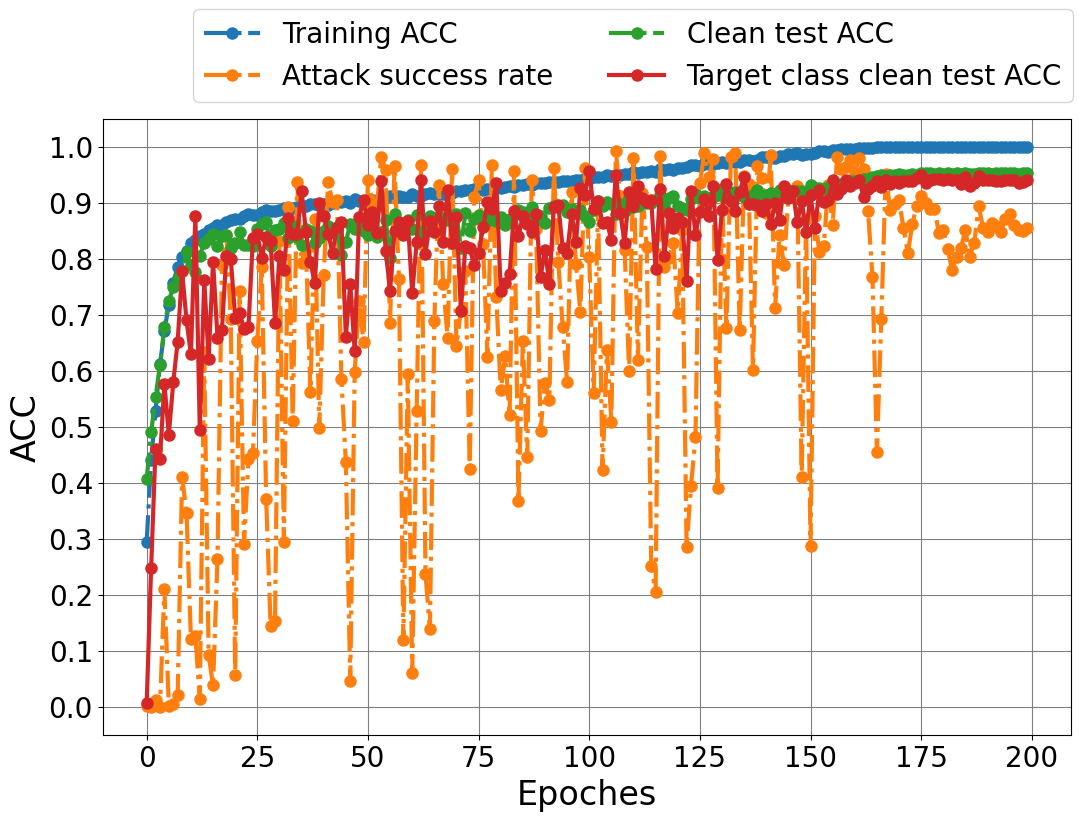

0.9999201596806387
attack 0.9112222222222223
175
all class clean 0.9533
target clean 0.949
Saved training and evaluation metrics to metrics_adaptive_trigger.json


In [32]:
#cell 27
#ours -- higher_configureations
from matplotlib import pyplot as plt
half = np.arange(0,training_epochs)
plt.figure(figsize=(12.5,8))
plt.plot(half, np.asarray(train_ACC)[half], label='Training ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(test_ACC)[half], label='Attack success rate', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(clean_ACC)[half], label='Clean test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(target_ACC)[half], label='Target class clean test ACC', linestyle="-", marker="o", linewidth=3.0, markersize = 8)
# plt.plot(half, np.asarray(test_unl_ACC)[half], label='protected test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.ylabel('ACC', fontsize=24)
plt.xticks(fontsize=20)
plt.xlabel('Epoches', fontsize=24)
plt.yticks(np.arange(0,1.1, 0.1),fontsize=20)
plt.legend(fontsize=20,bbox_to_anchor=(1.016, 1.2),ncol=2)
plt.grid(color="gray", linestyle="-")
plt.show()

dis_idx = clean_ACC.index(max(clean_ACC))
print(train_ACC[dis_idx])
print('attack',test_ACC[dis_idx])
print(clean_ACC.index(max(clean_ACC)))
print('all class clean', clean_ACC[dis_idx])
print('target clean',target_ACC[dis_idx])

import json

metrics = {
    "train_ACC": train_ACC,
    "test_ACC": test_ACC,
    "clean_ACC": clean_ACC,
    "target_ACC": target_ACC
}

with open("metrics_adaptive_trigger2.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved training and evaluation metrics to metrics_adaptive_trigger.json")
